# NLP Prediction

## Problem Overview
*__The Problem__*: Most (~92%) apartment listings on Craigslist for apartments list how many bedrooms the apartment possesses. However, not all do and the number of bedrooms is an important feature for predicting the price of an apartment. Despite about 8% of listings not filling in the field for bedrooms many of those do put the number of bedrooms in the title. For example, a Craigslist ad could for "Beautiful 2BR in Brooklyn", but they won't actually fill in the number of bedrooms. Thus when I scrape data we don't get 2 in the Bedroom field, but it seems like we could predict it based on the title. This notebook explores the idea of using the title of the ad to predict the number of bedrooms.

*__The Data__*: This notebook uses data on New York City apartments listed on Craigslist. This is not a Kaggle or publically available data set, but one made by my own AWS pipeline which is described [in this GitHub repo](https://github.com/scochran3/LazyApartment). The pipeline is created by a series of AWS Lambda functions that scrape apartment listing from Craigslist and then enrich that with additional data from various APIs. Luckily since 92% of people do put in the bedroom field we have a nice training data set with apartment ad titles and the number of bedrooms. This can be used to train our NLP model.

*__Why This Is an Issue__*: Many algorithms won't play nice with missing data, so it be nice if we could reliabily fill in the number of bedrooms (~8% missing) if our ultimate goal is to predict price of the apartment. The oversimplified pipeline will be: Collect Data -> Use NLP Model to fill in missing bedrooms -> Use other model to predict price.

## Libraries
(sorry I need to import everything at the top, I can't help it)

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from collections import Counter
import warnings
import pickle

#Scikit Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d
output_notebook()

# Keras libraries
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.sequence import pad_sequences
from keras import layers

# Set the stage
plt.rcParams['figure.figsize'] = (14.0, 10.0)
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth', 800)

Loading BokehJS ...

Using TensorFlow backend.


 ## Read in our data
If you view the Data Cleaning - NYC Apartments notebook it shows how we turn our raw data into a Pandas dataframe that we use here for our model.

In [2]:
df = pd.read_csv('../../notebooks/housing_cleaned.csv')[['name', 'bedrooms']]
df.dropna(inplace=True)

## Sample of our data

In [3]:
df.head(10)

,name,bedrooms
0,you’re in good hands...t e x t us to view bk’s best *no fee* apts,3.0
1,spacious 1br penthouse with deck!! near col univ!!,1.0
2,this is the one you’ve been looking for… call today to view,3.0
3,simplify your search with us**pro team w/ big inventory of no fee apts,3.0
4,sunny 1br in long island city. brand new renovation + no fee!,1.0
5,gorgeous true 1 bedroom in east village--e10/1st ave--no fee,1.0
6,spacious 2br just 1 block from l and m trains,2.0
7,beautiful renovated 3br - laundry in unit - no fee,3.0
8,granite countertops in this gorgeous 2br/2ba apartment!,2.0
9,"historic loft style 1br, heat included in rent!",1.0


In [4]:
df.shape

(22719, 2)

## Create a string with all of our text data
This is just so we can do some exploratory analysis of our text. There are methods in Keras and Scikit that do some of this for us automatically, but what fun is that?

In [5]:
tokens = []
for apartment in df['name']:
    tokenized_word=word_tokenize(apartment)
    for token in tokenized_word:
        tokens.append(token)

## Word Frequency

### Remove Stopwords

In [6]:
stop_words = stopwords.words('english')

# Remove stop words
tokens = [re.sub(r'[^\w\s]','', token) for token in tokens if token not in stop_words]

# Remove short words
tokens = [token.strip() for token in tokens if len(token) > 2]

### Plot word frequency
Now that we have our token list we can look at the most common words in our corpus.

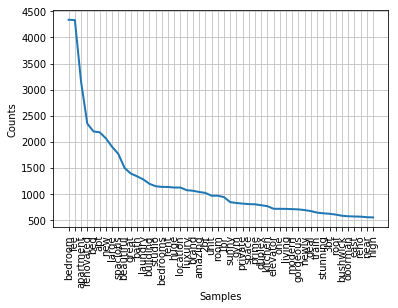

In [7]:
freq = nltk.FreqDist(tokens)
freq.plot(50, cumulative=False)

Man a lot of people in New York are mentioning the fees associated with renting an apartment! A lot of these words makes sense and are expected such as "bedroom", "apartment" and terms like "1BR/2BR/etc". You can also see how often people are using terms such as "renovated", "new", "spacious" and "beautiful" to really sell their listing.

## Word Cloud
5 years ago word clouds were all the rage with NLP so we may as well do one. Below shows the a word cloud, limiting it to the top 200 words. Basically it matches our word frequency plot above in a (maybe) prettier way.

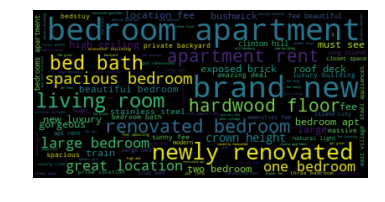

In [8]:
wordcloud = WordCloud(max_words=200).generate(' '.join(tokens))
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Baseline Model: Bag Of Words
Eventually we will use Keras and a Deep Neural Network (DNN) to fit a model to our text data. However, we should establish a simpler baseline model to compare that DNN to. We will use a Bag Of Words representation of our corpus along with some standard classifiers from Scikit (LDA, Logistic Regression, Naive Bayes) to establish our baseline models. 

__Side Note__: [This Medium article](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) is a good introduction to the Bag Of Words model for those unaware. Basically it represents our Corpus as a matrix where each feature (column) is the presence (or count) of a word, and the matrix will have a 0 for all words not in that document. It's a simple model, but a weakness is it loses context as order of the words is not taken into account. It's fairly painless to train and fit so it serves as a nice baseline.


### Vocab Pipeline Functions
We could use the CountVectorizer function from sklearn.feature_extration.text to automate a lot of this, but that's no fun. Thus we will write our own methods to get to our Bag Of Words representation. The following functions take our dataframe of apartment listings and output a text file with the entire vocabulary. That is, any word that is in the titles of our listings will be included. The exceptions will be any words that have a count less than our threshold count (e.g. no words with less than a count of 5). This is to prevent our feature matrix from becoming overly sparse.

In [9]:
# Get all the text from the apartment listings
def load_text(dataframe):
    text = ' '.join(dataframe['name'].tolist())
    
    return text

In [10]:
# Clean the tokens (remove stopwords, punctuation, etc.)
def clean_text(input_text):
    
    # Lower text
    input_text = input_text.lower()
    
    # Tokenize text
    tokens = word_tokenize(input_text)

    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens = [re.sub(r'[^\w\s]|_','', token) for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token.strip() for token in tokens if len(token) > 2]
    
    return tokens

In [11]:
# Remove words that don't have at least a minimum number of occurences
def clean_text_min_words(text, min_occurences=3):
    vocab = Counter(text)
    vocab_with_min_occurrences = [word for word, count 
                                      in vocab.items() if count >= min_occurences]
    
    return vocab_with_min_occurrences

In [12]:
# Export our vocab
def export_vocab(text, filename):
    text_data = '\n'.join(text)
    
    with open(filename, 'w', encoding='utf-8') as write_file:
        write_file.write(text_data)
        write_file.close()

### Text Data  Pipeline
The above functions establish our vocabulary: a unique set of words that are included in our listings. We also need functions to clean an individual listing. These functions will remove any words not in the vocab above and create a vectorized representation of the apartment listing. We can then run this over our entire dataframe to get a bag of words representation of our entire dataset.

In [13]:
# Clean an individual string
def individual_listing_text(line, vocab):
    
    # Clean the line of text
    clean_line = clean_text(line)
    
    # Keep only words in vocab
    clean_line = [token for token in clean_line if token in vocab]
    
    # Put it back together
    return ' '.join(clean_line)

In [14]:
# Clean an entire dataframe
def process_all_lines(dataframe, vocab):
    lines = []
    for listing in dataframe['name']:
        cleaned_text = individual_listing_text(listing, vocab)
        lines.append(cleaned_text)
    
    # Output is a list where each item is one listing where the text is cleaned
    return lines

In [15]:
# Create our train and test sets
def create_train_and_test(dataframe, train_portion=.85, validation_portion=.05):
    
    # Shuffle our data
    dataframe = shuffle(dataframe)
    response = dataframe['bedrooms'].tolist()
    
    # Split our training and test splits
    train_number_of_rows = int(train_portion * len(dataframe))
    validation_number_of_rows = int(validation_portion * len(dataframe))
    
    X_train = dataframe[0:train_number_of_rows]
    X_validation = dataframe[train_number_of_rows:(train_number_of_rows+validation_number_of_rows)]
    X_test = dataframe[(train_number_of_rows+validation_number_of_rows):]
    y_train = response[0:train_number_of_rows]
    y_validation = response[train_number_of_rows:(train_number_of_rows+validation_number_of_rows)]
    y_test = response[(train_number_of_rows+validation_number_of_rows):]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

def tokenize_train_and_test(X_train, X_validation, X_test, vocab, mode='count'):

    # Bring in Keras Tokenizer
    tokenizer = Tokenizer()
    
    # Tokenize the data
    X_train_processed = process_all_lines(X_train, vocab)
    X_validation_processed = process_all_lines(X_validation, vocab)
    X_test_processed = process_all_lines(X_test, vocab)
    tokenizer.fit_on_texts(X_train_processed)
    pickle.dump(tokenizer, open('log_reg_tokenizer.pickle', 'wb'))
    X_train_tokenized = tokenizer.texts_to_matrix(X_train_processed, mode=mode)
    X_validation_tokenized = tokenizer.texts_to_matrix(X_validation_processed, mode=mode)
    X_test_tokenized = tokenizer.texts_to_matrix(X_test_processed, mode=mode)
    
    return X_train_tokenized, X_validation_tokenized, X_test_tokenized

### Create our train and test sets

In [16]:
# Split the data into train and test
X_train, X_validation, X_test, y_train, y_validation, y_test = create_train_and_test(df, .8, .1)
# X_test.to_csv('X_test_lr.csv')

# Create our vocab based on our training data
text_data = load_text(X_train)
clean_text_data = clean_text(text_data)
vocab = clean_text_min_words(clean_text_data, 5)
export_vocab(vocab, 'vocab.txt')

# Tokenize X_train and X_test
X_train, X_validation, X_test = tokenize_train_and_test(X_train, X_validation, X_test, vocab=vocab)

In [17]:
# Check sizes
print (("""X_Train Size: {}\nX_Validation Size: {}\nX_Test Size: {}\ny_train Size: {}\ny_validation Size: {}\ny_test Size: {}"""
        .format(X_train.shape, X_validation.shape, X_test.shape,
                len(y_train), len(y_validation), len(y_test))))

X_Train Size: (18175, 1694)
X_Validation Size: (2271, 1694)
X_Test Size: (2273, 1694)
y_train Size: 18175
y_validation Size: 2271
y_test Size: 2273


## Fit Baseline Models
Now that our data is in a usable format we can fit a few baseline models. The pattern here will be the same for 3 different classifiers (Naive Bayes, Logistic Regression and LDA): 

- Define classifier
- Perform a Grid Search over that models important tuning parameters
- Fit with the best_estimator_
- Output a variety of scoring metrics and the accuracy

### Naive Bayes

In [18]:
# Define model
clf = MultinomialNB()

# Create Grod
grid = {'alpha': [.0001, .001, .01, .1, 1, 10, 100],
       'fit_prior': [True, False]}

# Fit the model
nb_grid_search = GridSearchCV(clf, 
                           param_grid=grid, 
                           cv=5)

nb_grid_search.fit(X_train, y_train)

# Predict!
nb_val_preds = nb_grid_search.predict(X_validation)
nb_accuracy = accuracy_score(nb_val_preds, y_validation)
report = classification_report(nb_val_preds, y_validation, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print ('------------------')
print(report_df)
print ('------------------')
print ('Achieved an accuracy of: {}'.format(nb_accuracy))
print ('------------------')
print ('Best Model: {}'.format(nb_grid_search.best_estimator_))

------------------
              f1-score  precision    recall  support
0.0           0.907563   0.972973  0.850394    127.0
1.0           0.708151   0.634223  0.801587    504.0
2.0           0.687084   0.708791  0.666667    774.0
3.0           0.690751   0.734255  0.652115    733.0
4.0           0.609442   0.586777  0.633929    112.0
5.0           0.687500   0.687500  0.687500     16.0
6.0           0.833333   0.714286  1.000000      5.0
micro avg     0.701453   0.701453  0.701453   2271.0
macro avg     0.731975   0.719829  0.756027   2271.0
weighted avg  0.701769   0.709080  0.701453   2271.0
------------------
Achieved an accuracy of: 0.7014531043593131
------------------
Best Model: MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


#### Final Test Set

In [19]:
nb_test_preds = nb_grid_search.predict(X_test)
nb_test_accuracy = accuracy_score(nb_test_preds, y_test)
nb_test_accuracy

0.7030356357237132

### Logistic Regression

In [20]:
# Define model
clf = LogisticRegression()

# Create Grod
grid = {'penalty': ['l1', 'l2'],
       'C': [.1, 1, 10, 100, 1000, 10000]}

# Fit the model
lr_grid_search = GridSearchCV(clf, 
                           param_grid=grid, 
                           cv=5)

lr_grid_search.fit(X_train, y_train)

# Predict!
lr_val_preds = lr_grid_search.predict(X_validation)
lr_accuracy = accuracy_score(lr_val_preds, y_validation)
report = classification_report(lr_val_preds, y_validation, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print ('------------------')
print(report_df)
print ('------------------')
print ('Achieved an accuracy of: {}'.format(lr_accuracy))
print ('------------------')
print ('Best Model: {}'.format(lr_grid_search.best_estimator_))

------------------
              f1-score  precision    recall  support
0.0           0.986425   0.981982  0.990909    110.0
1.0           0.790024   0.770801  0.810231    606.0
2.0           0.761204   0.781593  0.741851    767.0
3.0           0.774924   0.788018  0.762259    673.0
4.0           0.759259   0.677686  0.863158     95.0
5.0           0.800000   0.750000  0.857143     14.0
6.0           0.923077   0.857143  1.000000      6.0
micro avg     0.784676   0.784676  0.784676   2271.0
macro avg     0.827845   0.801032  0.860793   2271.0
weighted avg  0.784455   0.785982  0.784676   2271.0
------------------
Achieved an accuracy of: 0.7846763540290621
------------------
Best Model: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


#### Final Test Set

In [21]:
lr_test_preds = lr_grid_search.predict(X_test)
lr_test_accuracy = accuracy_score(lr_test_preds, y_test)
lr_test_accuracy

0.796304443466784

#### Pickle model

In [22]:
pickle.dump(lr_grid_search, open('log_regression.pickle', 'wb'))

### LDA

In [23]:
# Define model
clf = SGDClassifier()

# Create Grod
grid = {'loss': ['hinge', 'log', 'modified_huber'],
        'penalty': ['l1', 'l2'],
        'alpha': [.00001, .0001, .001, .01, ]}

# Fit the model
lda_grid_search = GridSearchCV(clf, 
                           param_grid=grid, 
                           cv=5)

lda_grid_search.fit(X_train, y_train)

# Predict!
lda_val_preds = lda_grid_search.predict(X_validation)
lda_accuracy = accuracy_score(lda_val_preds, y_validation)
report = classification_report(lda_val_preds, y_validation, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print ('------------------')
print(report_df)
print ('------------------')
print ('Achieved an accuracy of: {}'.format(lda_accuracy))
print ('------------------')
print ('Best Model: {}'.format(lda_grid_search.best_estimator_))

------------------
              f1-score  precision    recall  support
0.0           0.948276   0.990991  0.909091    121.0
1.0           0.741392   0.794349  0.695055    728.0
2.0           0.738567   0.743132  0.734057    737.0
3.0           0.743842   0.695853  0.798942    567.0
4.0           0.733945   0.661157  0.824742     97.0
5.0           0.750000   0.750000  0.750000     16.0
6.0           0.833333   0.714286  1.000000      5.0
micro avg     0.751651   0.751651  0.751651   2271.0
macro avg     0.784194   0.764252  0.815984   2271.0
weighted avg  0.752055   0.757435  0.751651   2271.0
------------------
Achieved an accuracy of: 0.7516512549537648
------------------
Best Model: SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_s

#### Final Test Set

In [24]:
lda_test_preds = lda_grid_search.predict(X_test)
lda_test_accuracy = accuracy_score(lda_test_preds, y_test)
lda_test_accuracy

0.7558293004839419

## Baseline Model Overview

In [25]:
models = ['Naive Bayes', 'Logistic Regression', 'LDA']
accuracies = [nb_test_accuracy, lr_test_accuracy, lda_test_accuracy]
baseline_df = pd.DataFrame({'Model':models, 'Accuracy': accuracies})

# Create Figure
source = ColumnDataSource(baseline_df)
p = figure(sizing_mode='stretch_width', y_range=baseline_df['Model'], tools=[], toolbar_location=None)
p.hbar(y='Model', right='Accuracy', height=.5, source=source)
p.x_range = Range1d(0, baseline_df['Accuracy'].max()*1.05)
show(p)

So far Logistic Regression is our best model with an accuracy of around 77%, which isn't bad given how quickly we were able to build this model.

## Keras - Neural Network
Let's see if one of those fancy schmancy deep neural networks that all the kids are raving about these days can out perform our traditional models. As of now our old friend Logistic Regression is our best model at an accuracy of around 80%. First we need to encode our response so it's in the proper format for Keras. The previous models could take a 1 dimensional vector but Keras requires needs a response matrix of N x C where N is the number of rows and C is the number of classes. Basically we need to one hot encode our response.

### Encode Response

In [26]:
# Train
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_train_encoded = np_utils.to_categorical(y_train_encoded)

# Validation
# encoder = LabelEncoder()
encoder.fit(y_validation)
y_validation_encoded = encoder.transform(y_validation)
y_validation_encoded = np_utils.to_categorical(y_validation_encoded)

# Test
# encoder = LabelEncoder()
encoder.fit(y_test)
y_test_encoded = encoder.transform(y_test)
y_test_encoded = np_utils.to_categorical(y_test_encoded)

y_train_encoded.shape

(18175, 7)

In [27]:
X_train.shape

(18175, 1694)

### Create our Neural Network Model

In [28]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(256, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               867840    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
__________

### Fit Model

In [29]:
history = model.fit(X_train, y_train_encoded,
                   epochs=5,
                   verbose=True,
                   validation_data=(X_validation, y_validation_encoded),
                   batch_size=32)

ValueError: Error when checking target: expected activation_5 to have shape (6,) but got array with shape (7,)

### Model Evaluation
By saving our fit model we can look at the performance over each iteration, or epoch. Let's plot how our accuracy, both training and test, looks over the epochs.

In [ ]:
# Plot Performance
def plot_nn_performance(history):
    df_accuracy = pd.DataFrame(data={'epoch': list(range(len(history.history['categorical_accuracy']))),
                                     'accuracy': history.history['categorical_accuracy'],
                                     'val_acc': history.history['val_categorical_accuracy']

                                    })

    source = ColumnDataSource(df_accuracy)
    p = figure(sizing_mode='stretch_width')
    p.line(x='epoch', y='accuracy', source=source, line_width=3, legend='accuracy ')
    p.line(x='epoch', y='val_acc', source=source, line_width=3, color='red', legend='validation accuracy ')
    p.legend.location = 'bottom_right'
    # p.y_range = Range1d(0, 1)
    show(p)

In [ ]:
plot_nn_performance(history)

Generally we see that around epoch number 5 our model has stagnated in terms of validation accuracy, so going forward it seems we can cut down drastically on the number of epochs (and run time). Overall our Neural Network has a good improvement over Logistic Regression, reaching an accuracy of around 85% (vs. 77% for Logistic Regression.

### Refit the model with a more appropriate training process
We will recompile the model and refit to make sure we don't take any of the learnings of the previous model. Here we will only train over 6 epochs as it seems there isn't much to gain after that.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_encoded,
                   epochs=6,
                   verbose=True,
                   validation_data=(X_validation, y_validation_encoded),
                   batch_size=32)


### Predicting our final test data
When we originally split our data we made train, validation and test set. We can now use that test set to get a final prediction.

In [ ]:
nn_test_accuracy = model.evaluate(X_test, y=y_test_encoded)[1]
nn_test_accuracy

In [ ]:
# preds = np.argmax(model.predict(X_test), -1)
# df = pd.read_csv('X_test_lr.csv')
# df['preds'] = preds

# accuracy_score(preds, df['bedrooms'].values)

We see that our deep neural network was able to achieve a test accuracy of 87.3%, which is a significant upgrade over the baseline model of Logisitc Regression (~78%)

## Word Embeddings Model
Our previous model used the Bag Of Words approach, where each feature was a word from our total vocabulary across the training set. The values were the number of occurences of those words in that line. Another strategy for turning text into a numerical matrix is to use word embeddings. At a high level, this groups similar words

In [ ]:
# Start fresh as we tokenized our data
df = pd.read_csv('../../notebooks/housing.csv')[['name', 'bedrooms']]
df.dropna(inplace=True)
sentences_train, sentences_validation, sentences_test, y_train, y_validation, y_test = create_train_and_test(df, .8, .1)

In [ ]:
# Train
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_train_encoded = np_utils.to_categorical(y_train_encoded)

# Validation
encoder = LabelEncoder()
encoder.fit(y_validation)
y_validation_encoded = encoder.transform(y_validation)
y_validation_encoded = np_utils.to_categorical(y_validation_encoded)

# Test
encoder = LabelEncoder()
encoder.fit(y_test)
y_test_encoded = encoder.transform(y_test)
y_test_encoded = np_utils.to_categorical(y_test_encoded)

In [ ]:
# Fit the Tokenizer to our text
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(sentences_train['name'].values)

# Export pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Create our tokenized versions of datasets
X_train = tokenizer.texts_to_sequences(sentences_train['name'].values)
X_validation = tokenizer.texts_to_sequences(sentences_validation['name'].values)
X_test = tokenizer.texts_to_sequences(sentences_test['name'].values)
num_of_words = len(tokenizer.word_index) + 1

In [ ]:
sentences_train['name'].head()

In [ ]:
X_train[0:5]

In [ ]:
# Make our vectors all the same length with padding
max_length = 25
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_validation = pad_sequences(X_validation, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

X_train[0:5]

In [ ]:
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim=num_of_words, 
                           output_dim=embedding_dim, 
                           input_length=max_length))
model.add(layers.Flatten())
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(32, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train_encoded,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_validation, y_validation_encoded),
                    batch_size=32)
plot_nn_performance(history)

### Fit reduced model with fewer epochs

In [ ]:
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim=num_of_words, 
                           output_dim=embedding_dim, 
                           input_length=max_length))
model.add(layers.Flatten())
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(32, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])
model.summary()
history = model.fit(X_train, y_train_encoded,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_validation, y_validation_encoded),
                    batch_size=32)
nn_we_test_accuracy = model.evaluate(X_test, y=y_test_encoded)[1]
nn_we_test_accuracy

## Convolutional Neural Network

In [ ]:
embedding_dim = 100
model = Sequential()
model.add(layers.Embedding(num_of_words, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train_encoded,
                    epochs=30,
                    verbose=True,
                    validation_data=(X_validation, y_validation_encoded),
                    batch_size=32)
plot_nn_performance(history)

### Fit reduced model with fewer epochs

In [ ]:
embedding_dim = 100
model = Sequential()
model.add(layers.Embedding(num_of_words, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
history = model.fit(X_train, y_train_encoded,
                    epochs=3,
                    verbose=False,
                    validation_data=(X_validation, y_validation_encoded),
                    batch_size=32)

## Export our CNN

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")